In [1]:
import sys
sys.path.append('../')  # Add the parent directory to the Python path
from dsaa_code.models.cnns import Custom_ResNet34
import math

In [2]:
import torch
import json
from PIL import Image
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor
from torch.nn.functional import softmax
import warnings
warnings.simplefilter("ignore", Warning)
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.metrics import confusion_matrix
from datetime import timedelta

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:1' if use_cuda else 'cpu')
print(torch.cuda.device_count())
torch.backends.cudnn.benchmark = True

2


In [4]:
class MyJP2Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 0]), self.annotations.iloc[index, 2])
        hmi = Image.open(img_path)

        if self.transform:
            image = self.transform(hmi)
            
        file = self.annotations.iloc[index, 2]
        goes_class = self.annotations.iloc[index, 3]
        y_label = torch.tensor(int(self.annotations.iloc[index, 4]))
        LON_FWT = str(self.annotations.iloc[index, 6])
        # lg_scale = torch.tensor(int(self.annotations.iloc[index, -1]))
        
        return (image, y_label, file, goes_class, LON_FWT)

    def __len__(self):
        return len(self.annotations)

In [5]:
datapath = '/data/SHARPS/preprocessed_SHARPS_JPGS/stride_based_hourly_all/'
val = '../labels/val_new.csv'
test = '../labels/test_new.csv'
#Define Transformations
transformations = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
val_set = MyJP2Dataset(csv_file = val, 
                            root_dir = datapath,
                            transform = transformations)

test_set = MyJP2Dataset(csv_file = test, 
                            root_dir = datapath,
                            transform = transformations)


val_loader = DataLoader(dataset=val_set, batch_size=512, num_workers=8, pin_memory = True, shuffle = False)
test_loader = DataLoader(dataset=test_set, batch_size=512, num_workers=8, pin_memory = True, shuffle = False)

In [7]:
model_PATH1_bce = '../trained_models/bce.pth'
model_PATH2_bcesf = '../trained_models/bce_sf.pth'
bce_wt = torch.load(model_PATH1_bce)
bcesf_wt = torch.load(model_PATH2_bcesf)
resnet = Custom_ResNet34(ipt_size=(512, 512)).to(device)

In [8]:
def sklearn_Compatible_preds_and_targets(model_prediction_list, model_target_list, model_path_list, model_goes_list, model_LON_FWT_list):
    y_pred_list = []
    preds = []
    target_list = []
    tgts = []
    path_list = []
    path = []
    goes_list = []
    goes = []
    LON_FWT_list = []
    LON_FWT = []
    y_pred_list = [a.squeeze().tolist() for a in model_prediction_list]
    preds = [item for sublist in y_pred_list for item in sublist]
    target_list = [a.squeeze().tolist() for a in model_target_list]
    tgts = [item for sublist in target_list for item in sublist]
    path_list = [a for a in model_path_list]
    path = [item for sublist in path_list for item in sublist]
    
    goes_list = [a for a in model_goes_list]
    goes = [item for sublist in goes_list for item in sublist]
    LON_FWT_list = [a for a in model_LON_FWT_list]
    LON_FWT = [item for sublist in LON_FWT_list for item in sublist]
    return preds,tgts, path, goes, LON_FWT


def accuracy_score(prediction, target):
    TN, FP, FN, TP = confusion_matrix(target, prediction).ravel()
    print("TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)
    #TSS Computation also known as "recall"
    tp_rate = TP / float(TP + FN) if TP > 0 else 0  
    fp_rate = FP / float(FP + TN) if FP > 0 else 0
    TSS = tp_rate - fp_rate
    
    #HSS2 Computation
    N = TN + FP
    P = TP + FN
    HSS = (2 * (TP * TN - FN * FP)) / float((P * (FN + TN) + (TP + FP) * N))
    
    geomean = math.sqrt(abs(TSS)*abs(HSS))

    return TSS, HSS, geomean

In [9]:
def predict(checkpoint, test_model, test_loader, desc ):
    test_target_list=[]
    test_prediction_list=[]
    test_path_list = []
    test_goes_list = []
    test_lonfwt_list = []
    test_model.load_state_dict(checkpoint['model_state_dict'])
    test_model.eval()
    print('***********************', desc, '*************************')
    with torch.no_grad():
        for d, t, path, goes, lonfwt in test_loader:
            # Get data to cuda if possible
            d = d.to(device=device)
            t = t.to(device=device)

            test_target_list.append(t)
            test_path_list.append(list(path))
            test_goes_list.append(list(goes))
            test_lonfwt_list.append(list(lonfwt))

            s = test_model(d)

            p = softmax(s,dim=1)
#             print(p.shape)

            test_prediction_list.append(p[:,1])

            del d,t,s,p
            
    a, b, pth, gc, lon = sklearn_Compatible_preds_and_targets(test_prediction_list, test_target_list,
                                                   test_path_list,test_goes_list, test_lonfwt_list)
    preds = [int(i >=0.5) for i in a]
    print(accuracy_score(preds, b))
    prob_list = pd.DataFrame(
    {
     'flare_prob': a,
     'target': b,
     'path': pth,
     'goes_class': gc,
     'lon_fwt': lon
    })

    print(prob_list['target'].value_counts())
#     prob_list['timestamp'] = prob_list['timestamp'].apply(lambda row: row[35:-4])
#     prob_list['timestamp'] = pd.to_datetime(prob_list['timestamp'], format='%Y.%m.%d_%H.%M.%S')
    return prob_list

In [10]:
print('*********************** BCE *************************')
bce_val = predict(bce_wt, resnet, val_loader, 'Validation')
bce_test = predict(bce_wt, resnet, test_loader, 'Test')

print('\n\n')
print('*********************** BCESF *************************')
bcesf_val = predict(bcesf_wt, resnet, val_loader, 'Validation')
bcesf_test = predict(bcesf_wt, resnet, test_loader, 'Test')

*********************** BCE *************************
*********************** Validation *************************
TP:  1765 FP:  8690 TN:  116382 FN:  613
(0.6727403737062254, 0.2523420068357761, 0.4120202130727071)
target
0    125072
1      2378
Name: count, dtype: int64
*********************** Test *************************
TP:  2108 FP:  8862 TN:  121003 FN:  990
(0.6121988974148727, 0.2732800580765497, 0.4090253662548768)
target
0    129865
1      3098
Name: count, dtype: int64



*********************** BCESF *************************
*********************** Validation *************************
TP:  1749 FP:  8236 TN:  116836 FN:  629
(0.6696419397330418, 0.2606581446142492, 0.41778897252883723)
target
0    125072
1      2378
Name: count, dtype: int64
*********************** Test *************************
TP:  1972 FP:  8187 TN:  121678 FN:  1126
(0.5734973128598037, 0.2714882639592043, 0.3945855925570227)
target
0    129865
1      3098
Name: count, dtype: int64


In [11]:
def save_results(data, name, model_name):
    data.to_csv(f'{model_name}.csv', index=False, header=True,
                columns=['flare_prob', 'target', 'path', 'goes_class', 'lon_fwt'])
save_results(bce_val, 'val', 'bce_val')
save_results(bce_test, 'test', 'bce_test')
# save_results(bcesf_val, 'val', 'bcesf_val')
# save_results(bcesf_test, 'test', 'bcesf_test')

### LATER ADDED MODEL

In [24]:
model_PATH3_bcesf = '../trained_models/best_loss_ord_ce.pth'
bcesf_wt_new = torch.load(model_PATH3_bcesf)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 44.40 GiB of which 3.31 MiB is free. Process 169810 has 42.68 GiB memory in use. Process 1741869 has 1.70 GiB memory in use. Of the allocated memory 319.65 MiB is allocated by PyTorch, and 26.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [23]:
print('*********************** BCESF *************************')
bcesf_val_new = predict(bcesf_wt_new, resnet, val_loader, 'Validation')
bcesf_test_new = predict(bcesf_wt_new, resnet, test_loader, 'Test')

*********************** BCESF *************************
*********************** Validation *************************


KeyboardInterrupt: 

In [ ]:
save_results(bcesf_val_new, 'val', 'bcesf_val_new')
save_results(bcesf_test_new, 'test', 'bcesf_test_new')

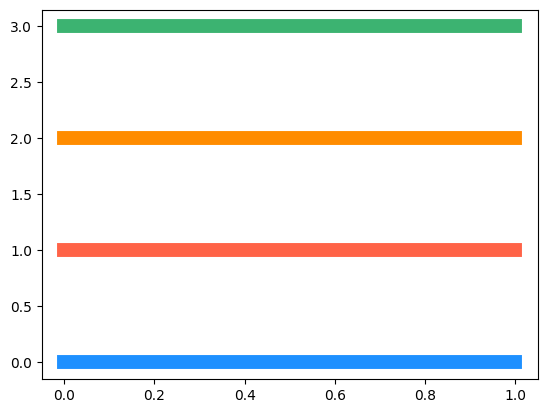

In [22]:
import matplotlib.pyplot as plt

colors = ['#1E90FF', '#FF6347', '#FF8C00','#3CB371']

fig, ax = plt.subplots()
for i, color in enumerate(colors):
    ax.plot([0, 1], [i, i], color=color, linewidth=10)

plt.show()
